In [48]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style
import math
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures,scale
from sklearn.pipeline import make_pipeline
%matplotlib inline


In [49]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("GOOG", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,807.900024,792.203979,795.260010,806.150024,1640200.0,806.150024
2017-01-09,809.966003,802.830017,806.400024,806.650024,1274600.0,806.650024
2017-01-10,809.130005,803.510010,807.859985,804.789978,1176800.0,804.789978
2017-01-11,808.150024,801.369995,805.000000,807.909973,1065900.0,807.909973
2017-01-12,807.390015,799.169983,807.140015,806.359985,1353100.0,806.359985


In [50]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

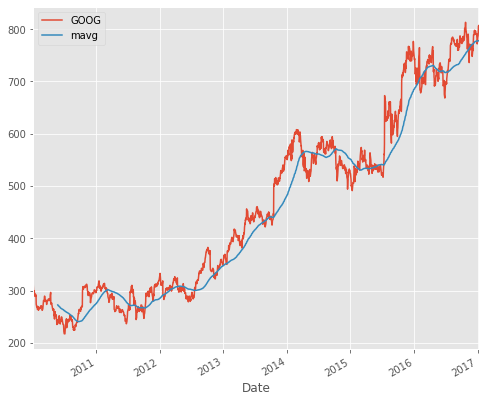

In [51]:
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='GOOG')
mavg.plot(label='mavg')
plt.legend()

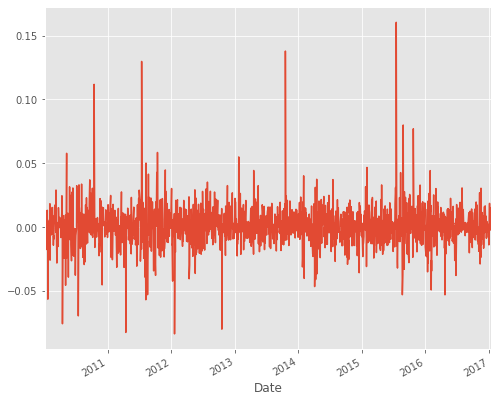

In [52]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [53]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [54]:
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2010-01-04,26.681330,10.781219,312.204773,98.142967,24.443624
2010-01-05,26.727465,10.837044,310.829926,96.957375,24.451517
2010-01-06,26.302330,10.781219,302.994293,96.327530,24.301458
2010-01-07,26.253704,11.339470,295.940735,95.994110,24.048725
2010-01-08,26.428249,11.583703,299.885956,96.957375,24.214581


In [55]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Text(0, 0.5, 'Returns AAPL')

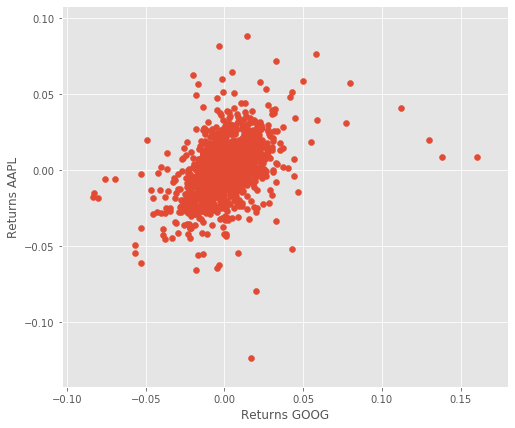

In [56]:
plt.scatter(retscomp.GOOG, retscomp.AAPL)
plt.xlabel('Returns GOOG')
plt.ylabel('Returns AAPL')

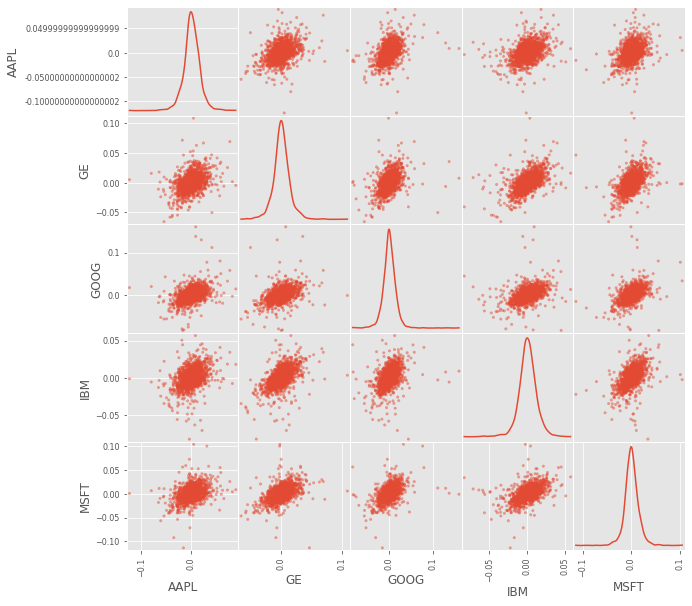

In [57]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

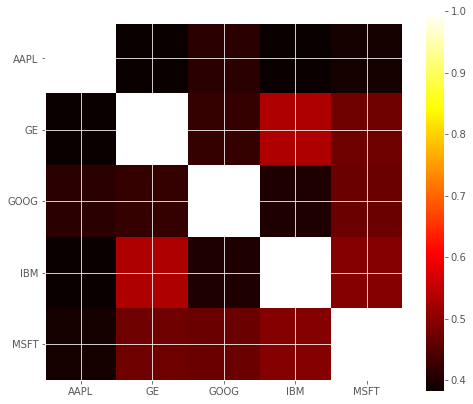

In [58]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

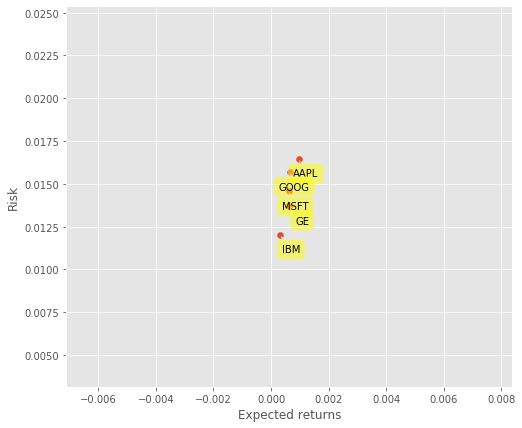

In [59]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [60]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [61]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,312.204773,3927000.0,0.840843,-0.031905
2010-01-05,310.829926,6031900.0,1.009634,-0.508628
2010-01-06,302.994293,7987100.0,3.205866,-2.812134
2010-01-07,295.940735,12876600.0,2.920385,-2.510665
2010-01-08,299.885956,9483900.0,2.348763,1.692571


In [62]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [64]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [65]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)

In [67]:
print(confidencereg, confidencepoly2, confidencepoly3)

0.9727236474283992 0.9729143351001305 0.9710778636676038


In [68]:
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

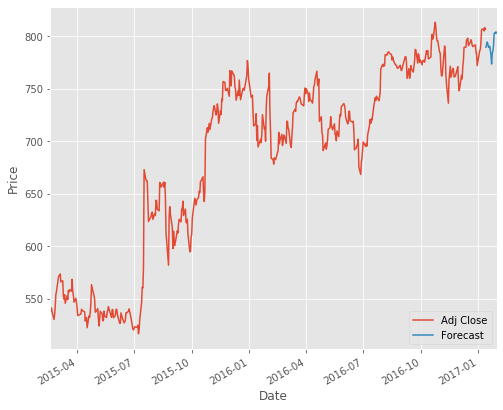

In [69]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [70]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoLars, BayesianRidge

In [71]:
clfRidge = Ridge()
clfLasso = Lasso()
clfElastic = ElasticNet()
clfLars = LassoLars()
clfBayes = BayesianRidge()

In [72]:
clfRidge.fit(X_train, y_train)
clfLasso.fit(X_train, y_train)
clfElastic.fit(X_train, y_train)
clfLars.fit(X_train, y_train)
clfBayes.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [73]:
scores={}
scores['ride']=clfRidge.score(X_test,y_test)
scores['lasso']=clfLasso.score(X_test,y_test)
scores['elastic']=clfElastic.score(X_test,y_test)
scores['lars']=clfLars.score(X_test,y_test)
scores['bayes']=clfBayes.score(X_test,y_test)

In [79]:
max(scores.values())

0.9727221072733986

In [101]:
sc =list(scores.values())

In [102]:
sc.sort(reverse=True)

In [103]:
sc

[0.9727221072733986,
 0.9727076838927496,
 0.972487257584467,
 0.9267750915346371,
 0.8606938144207749]

In [85]:
list(scores.keys())[list(scores.values()).index(max(scores.values()))]

'bayes'

In [90]:
def showmodel(model,_title):
    forecast_set = model.predict(X_lately)
    dfreg['Forecast'] = np.nan
    last_date = dfreg.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)

    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.title(_title)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

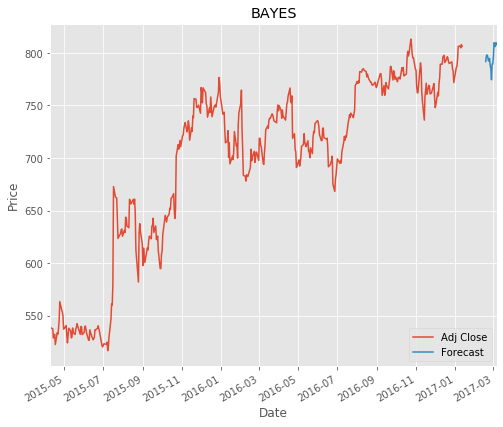

In [91]:
showmodel(clfBayes,'BAYES')

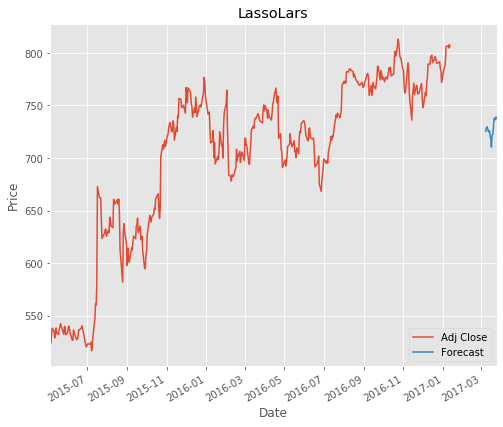

In [104]:
showmodel(clfLars,'LassoLars')

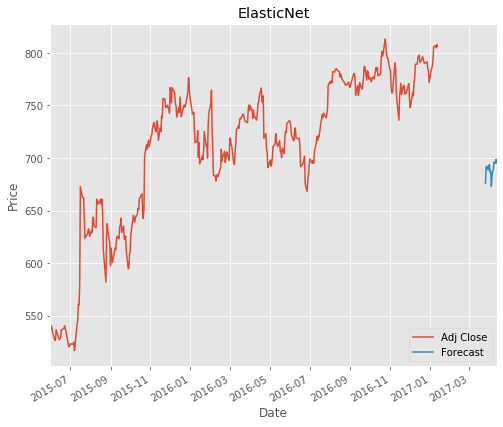

In [105]:
showmodel(clfElastic,'ElasticNet')